## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import skimage.feature
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

## Load CIFAR-10

In [2]:
# the cifar-10 dataset has been loaded from keras as it is in a good format
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

print("Train data and labels:")
print(x_train.shape)
print(y_train.shape)

print("Test data and labels:")
print(x_test.shape)
print(y_test.shape)

Train data and labels:
(50000, 32, 32, 3)
(50000, 1)
Test data and labels:
(10000, 32, 32, 3)
(10000, 1)


## SVM

The width, height and colour channels of each sample are converted into a vector containing the histogram of oriented gradients. This is done so the image can be processed by the svm. 

In [3]:
# HOG for training set
hog_train = []
for sample in tqdm(range(len(x_train))):
    hog_feature = skimage.feature.hog(x_train[sample], pixels_per_cell=[4,4], cells_per_block=[1,1],
                                                channel_axis=2)
    hog_train.append(hog_feature)

100%|██████████| 50000/50000 [02:46<00:00, 300.41it/s]


In [4]:
# HOG for testing set
hog_test = []
for sample in tqdm(range(len(x_test))):
    hog_feature = skimage.feature.hog(x_test[sample], pixels_per_cell=[4,4], cells_per_block=[1,1],
                                                channel_axis=2)
    hog_test.append(hog_feature)

100%|██████████| 10000/10000 [00:32<00:00, 304.32it/s]


In [5]:
print(np.shape(hog_train))

(50000, 576)


pre-processing (standardise)

In [6]:
standardiser = StandardScaler()
standardiser.fit(hog_train)
hog_train = standardiser.transform(hog_train)
hog_test = standardiser.transform(hog_test)

In [7]:
print(hog_train.shape)

(50000, 576)


In [8]:
# make labels 1d
y_train = y_train[:,0]
print(y_train.shape)

(50000,)


In [9]:
svm = SVC(max_iter = 100)
svm.fit(hog_train, y_train)
predict = svm.predict(hog_test) 

C:\Users\Excalibur\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


fit

In [10]:
print(svm.score(hog_test, y_test))

0.3258


## CNN:

Build model

because this problem is more complex than something like digit recognition, but less complex than identifying someones ethnicity, the model is of moderate size.

In [36]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(10))

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 13, 13, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 6, 6, 32)         0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 1152)              0         
                                                                 
 dense_4 (Dense)             (None, 64)               

Compile and train model using adam optimiser and 10 epochs

In [37]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=10, 
                    validation_data=(x_test, y_test))


Epoch 1/10
1563/1563 [==============================] - 41s 26ms/step - loss: 2.5181 - accuracy: 0.2080 - val_loss: 1.7983 - val_accuracy: 0.3310
Epoch 2/10
1563/1563 [==============================] - 42s 27ms/step - loss: 1.7818 - accuracy: 0.3375 - val_loss: 1.5882 - val_accuracy: 0.4174
Epoch 3/10
1563/1563 [==============================] - 38s 24ms/step - loss: 1.6088 - accuracy: 0.4089 - val_loss: 1.4512 - val_accuracy: 0.4740
Epoch 4/10
1563/1563 [==============================] - 40s 26ms/step - loss: 1.4928 - accuracy: 0.4606 - val_loss: 1.3341 - val_accuracy: 0.5266
Epoch 5/10
1563/1563 [==============================] - 36s 23ms/step - loss: 1.4000 - accuracy: 0.4980 - val_loss: 1.2837 - val_accuracy: 0.5433
Epoch 6/10
1563/1563 [==============================] - 37s 24ms/step - loss: 1.3220 - accuracy: 0.5339 - val_loss: 1.2063 - val_accuracy: 0.5750
Epoch 7/10
1563/1563 [==============================] - 38s 24ms/step - loss: 1.2613 - accuracy: 0.5543 - val_loss: 1.1922 -

training curves

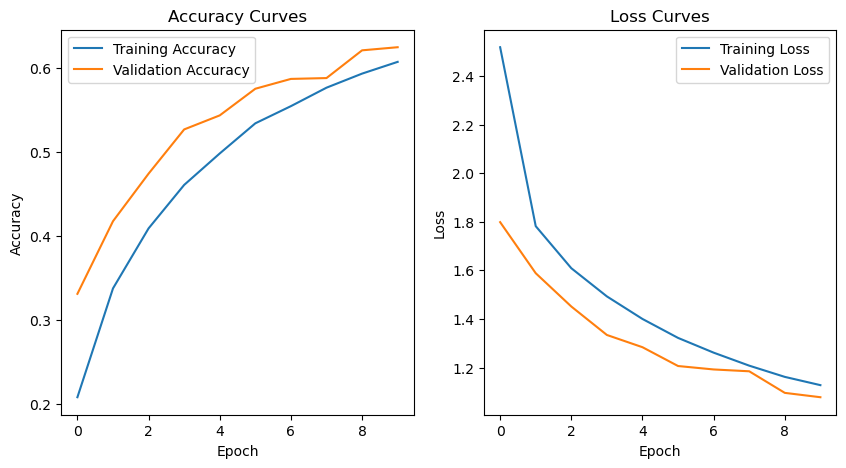

In [38]:
plt.figure(figsize=[10,5])
plt.subplot(121)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy',
           'Validation Accuracy'])
plt.title('Accuracy Curves')

plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss',
           'Validation Loss'])
plt.title('Loss Curves')
plt.show()